In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import csv
import glob
import re
import constant

# Default plot parameters
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['figure.dpi'] = 80
matplotlib.rcParams['figure.figsize'] = [5, 5]
cm = plt.cm.get_cmap('RdBu')
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':20,
         'ytick.labelsize':20}
plt.rcParams.update(params)
matplotlib.rcParams['font.sans-serif'] = "Arial"
plt.rcParams.update({'figure.autolayout': False})

In [2]:
class benchmark ():
    def __init__(self, datasets, power, area):
        self.benchmarks = datasets
        self.power = power
        self.area = area
        self.numBase = 100
        self.numTest = 100
        self.numTile = 64
        self.numCorePerTile = 16
        self.numRowPerCAM = 256
        self.numRouter = 21
        self.clock = 1e-9 # s
        self.colors = ['#FEC901', '#FF8300', '#01A982', '#2CBCE4']
        self.edgeColors = ['#BE9701', '#BF6200', '#0D5265', '#2CBCE4']
        
        self.instance = {
            "Node" : 1,
            "Tile" : self.numTile,
            "Core" : self.numTile*self.numCorePerTile,
            "Router" : self.numRouter,
            "ACAM" : self.numTile*self.numCorePerTile,
            "MPE" : self.numTile*self.numCorePerTile*self.numRowPerCAM,
            "MMR" : self.numTile*self.numCorePerTile*self.numRowPerCAM
        }
    
    def loadTreeSize(self, dataset):
        self.benchmarks[dataset]['treeSize'] = np.load(f"../model/{dataset}/tree_size.npy")
    
    def loadCPUPerformance(self, dataset):
        self.benchmarks[dataset]['CPU.Latency'] = np.load(f"../model/{dataset}/cpu_latency.npy")
        self.benchmarks[dataset]['CPU.Throughput'] = np.load(f"../model/{dataset}/cpu_throughput.npy")
        self.benchmarks[dataset]['CPU.Energy'] = self.numTest/self.benchmarks[dataset]['CPU.Throughput']*self.power['CPU']
    
    def loadGPUPerformance(self, dataset):
        self.benchmarks[dataset]['GPU.Latency'] = np.load(f"../model/{dataset}/gpu_latency.npy")
        self.benchmarks[dataset]['GPU.Throughput'] = np.load(f"../model/{dataset}/gpu_throughput.npy")
        self.benchmarks[dataset]['GPU.Energy'] = self.numTest/self.benchmarks[dataset]['GPU.Throughput']*self.power['GPU']
    
    def loadCAMPerformance(self, dataset):
        folder = self.benchmarks[dataset]['logFolder']
        with open(f"../log/{folder}/0/raw/latency.txt0", 'r') as file:
            lines = file.readlines()
        latencySST = 1e-6*np.array([int(line.split()[0]) for line in lines])
        self.benchmarks[dataset]['Total time'] = latencySST[-1]
        
        latency = latencySST[0]
        throughput = self.numTest/latencySST[-1]
        overhead = 0.1
        numCopy = np.maximum(1, (1-overhead)*np.floor(self.numTile/np.ceil(self.benchmarks[dataset]['treeSize']/(self.numCorePerTile*self.numRowPerCAM))))
        
        self.benchmarks[dataset]['CAM.Latency'] = latency*np.ones_like(self.benchmarks[dataset]['GPU.Latency'])
        self.benchmarks[dataset]['CAM.Throughput'] = numCopy*throughput*np.ones_like(self.benchmarks[dataset]['GPU.Throughput'])
        self.benchmarks[dataset]['CAM.Energy'] = self.loadEnergySST(dataset)*np.ones_like(self.benchmarks[dataset]['GPU.Energy'])
    
    def loadEnergySST(self, dataset):
        self.updateStaticEnergy(dataset)
        folder = self.benchmarks[dataset]['logFolder']
        for statFile in glob.glob(f"../log/{folder}/0/raw/Output_*.csv"):
            with open(statFile, 'r') as csv_file:
                csv_reader = csv.reader(csv_file, delimiter=',')
                _ = next(csv_reader)
                for row in csv_reader:
                    self.updateDynamicEnergy(row, dataset)
                    
        totalEnergy = 0.0
        for comp in ['Node', 'Router', 'Tile', 'Core', 'ACAM', 'MPE', 'MMR']:
            totalEnergy += self.benchmarks[dataset][f"{comp}.Energy"]    
        return totalEnergy
                    
    def updateDynamicEnergy(self, row, dataset):
        compName = row[0]
        if (compName == "Node_ctrl"):
            stage = re.findall('activeCycle(\S*)', row[1])[0]
            if (stage):
                self.benchmarks[dataset]['Node.Energy'] += float(row[6])*self.power[f"Node.{stage}"]*self.clock
        elif (re.findall('Router\d*', compName)):
            stage = re.findall('activeCycle(\S*)', row[1])[0]
            if (stage):
                self.benchmarks[dataset]['Router.Energy'] += float(row[6])*self.power[f"Router.{stage}"]*self.clock
        elif (re.findall('T\d*_ctrl', compName)):
            stage = re.findall('activeCycle(\S*)', row[1])[0]
            if (stage):
                self.benchmarks[dataset]['Tile.Energy'] += float(row[6])*self.power[f"Tile.{stage}"]*self.clock
        elif (re.findall('T\d*C\d*_ctrl', compName)):
            stage = re.findall('activeCycle(\S*)', row[1])[0]
            if (stage):
                self.benchmarks[dataset]['Core.Energy'] += float(row[6])*self.power[f"Core.{stage}"]*self.clock
        elif (re.findall('T\d*C\d*_acam', compName)):
            if (row[1] == ' energyCAM'):
                self.benchmarks[dataset]['ACAM.Energy'] += float(row[11])*1e-15*2
            else:
                self.benchmarks[dataset]['Core.Energy'] += float(row[11])*1e-15*2
        elif (re.findall('T\d*C\d*__mpe', compName)):
            self.benchmarks[dataset]['MPE.Energy'] += float(row[6])*self.numRowPerCAM*self.power["MPE.Active"]*self.clock
    
    def updateStaticEnergy(self, dataset):
        self.power["ACAM.Static"] = 0
        for comp in ['Node', 'Router', 'Tile', 'Core', 'ACAM', 'MPE', 'MMR']:
            self.benchmarks[dataset][f"{comp}.Energy"] = self.instance[comp]*self.power[f"{comp}.Static"]*self.benchmarks[dataset]['Total time']
    
    def loadPerformance(self):
        for dataset in self.benchmarks.keys():
            self.loadTreeSize(dataset)
            self.loadCPUPerformance(dataset)
            self.loadGPUPerformance(dataset)
            self.loadCAMPerformance(dataset)
            
    def plotScatterMultipleDataset(self):
        
        fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize=(10, 6))
        ylabel = {"Throughput": "Throughput\n(sample/s)", "Latency" : "Latency (s)"}
        ylim = {"Throughput" : (2e-1, 10e5), "Latency" : (1e-5, 1e1)}
        ytick = {"Throughput" : [1e1, 1e3, 1e5], "Latency" : [1e-4, 1e-2, 1e0]}
        xlim = (2e2, 0.5e6)
        xtick = np.array([1e3, 1e4, 1e5])
        labelSize = 20
        tickSize = 20
        textSize = 16
        maxSize = 262144
            
        for j, metric in enumerate(['Throughput', 'Latency']):
            for i, dataset in enumerate(self.benchmarks.keys()):
                treeSize = self.benchmarks[dataset]['treeSize']
                cpu = self.benchmarks[dataset][f"CPU.{metric}"] * (treeSize <= maxSize)
                gpu = self.benchmarks[dataset][f"GPU.{metric}"] * (treeSize <= maxSize)
                cam = self.benchmarks[dataset][f"CAM.{metric}"] * (treeSize <= maxSize)
                
                axes[j, i].scatter(treeSize, cpu, label="CPU", marker="^", color=self.colors[0], edgecolors=self.edgeColors[0], alpha=0.5)
                axes[j, i].scatter(treeSize, gpu, label="GPU", marker="s", color=self.colors[1], edgecolors=self.edgeColors[1], alpha=0.5)
                axes[j, i].axhline(y=np.min(cam[cam>0]), color=self.colors[2], linewidth=2, linestyle='--')
                axes[j, i].scatter(treeSize, cam, label="CAMSHAP", marker="o", color=self.colors[2], edgecolors=self.edgeColors[2], alpha=0.5)
                axes[j, i].set_xlim(xlim)
                axes[j, i].set_xscale('log')
                axes[j, i].set_yscale('log')
                axes[j, i].set_yticks([])
                axes[j, i].set_ylim(ylim[metric])
                axes[0, i].set_title(dataset, fontsize=labelSize)
            axes[j, 0].set_yticks(ytick[metric], fontsize=tickSize)
            axes[j, 0].set_ylabel(ylabel[metric], fontsize=labelSize)
        axes[1, 2].set_xlabel("Total number of leaves", fontsize=labelSize)
        fig.tight_layout()
        fig.subplots_adjust(wspace=0.0, hspace=0.0)
    
    def plotRelBarWithEnergy(self):
        
        fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize=(9, 8))
        yscale = {"Throughput" : 'log', "Latency" : 'log', "Energy" : 'linear'}
        ylim = {"Throughput" : (5e-1, 1e4), "Latency" : (5e-1, 1e4), "Energy" : (0, 500)}
        ytick = {"Throughput" : [1e1, 1e3], "Latency" : [1e1, 1e3], "Energy" : [0, 200, 400]}
        ylabel = {"Throughput" : 'Throughput\nspeedup', "Latency" : 'Latency\nspeedup', "Energy" : 'Energy\nefficiency'}
        width = 0.4
        labelSize = 20
        tickSize = 20
        textSize = 16
        xticklabel = list(self.benchmarks.keys())
        numDataset = len(xticklabel)
        for j, metric in enumerate(['Throughput', 'Latency', 'Energy']):
            geoMean = np.ones(2)
            for i, dataset in enumerate(self.benchmarks.keys()):
                index = self.benchmarks[dataset]['index']
                cpu = self.benchmarks[dataset][f"CPU.{metric}"][index]
                gpu = self.benchmarks[dataset][f"GPU.{metric}"][index]
                cam = self.benchmarks[dataset][f"CAM.{metric}"][index]
                
                if (metric=="Throughput"):
                    ratioCPU = cam/cpu
                    ratioGPU = cam/gpu
                else:
                    ratioCPU = cpu/cam
                    ratioGPU = gpu/cam
                geoMean[0] *= ratioCPU
                geoMean[1] *= ratioGPU
                    
                axes[j].bar(i - 0.5*width, ratioCPU, 0.9*width, ec='k', fc=self.colors[0], fill = True)
                axes[j].bar(i + 0.5*width, ratioGPU, 0.9*width, ec='k', fc=self.colors[1], fill = True)
                axes[j].text(i - 0.5*width, 1.1*ratioCPU, f"{ratioCPU:.0f}", size=textSize, rotation=0, horizontalalignment='center', verticalalignment='bottom')
                axes[j].text(i + 0.5*width, 1.1*ratioGPU, f"{ratioGPU:.0f}", size=textSize, rotation=0, horizontalalignment='center', verticalalignment='bottom')
                axes[j].axvline(x=i+1-0.5, color="k", lw=0.5, linestyle='--', zorder=-1)
            
            geoMean[0] = geoMean[0]**(1/numDataset)
            geoMean[1] = geoMean[1]**(1/numDataset)
            axes[j].bar(numDataset - 0.5*width, geoMean[0], 0.9*width, ec='k', fc=self.colors[0], fill = True, label='vs CPU', hatch="/")
            axes[j].bar(numDataset + 0.5*width, geoMean[1], 0.9*width, ec='k', fc=self.colors[1], fill = True, label='vs GPU', hatch="/")
            axes[j].text(numDataset - 0.5*width, 1.1*geoMean[0], f"{np.floor(geoMean[0]):.0f}", size=textSize, rotation=0, horizontalalignment='center', verticalalignment='bottom', fontweight='bold')
            axes[j].text(numDataset + 0.5*width, 1.1*geoMean[1], f"{np.floor(geoMean[1]):.0f}", size=textSize, rotation=0, horizontalalignment='center', verticalalignment='bottom', fontweight='bold')
            axes[j].axvline(x=numDataset-0.5, color="k", lw=0.5, zorder=-1)

            axes[j].set_yscale(yscale[metric])
            axes[j].set_ylim(ylim[metric])
            axes[j].set_yticks(ytick[metric], fontsize=tickSize)
            axes[j].set_ylabel(ylabel[metric], fontsize=labelSize)
            axes[j].set_xticks([])
            axes[j].set_xlim([-0.5, numDataset+0.5])
            
        xticklabel.append('geo.mean')
        axes[j].set_xticks(ticks=np.arange(numDataset+1), labels = xticklabel, fontsize=tickSize)
        
        fig.tight_layout(pad=2)
        fig.subplots_adjust(hspace=0.0)
        
    def plotPie(self, dataset='mortality'):
        fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 5))
        textSize = 20
        
        data = self.benchmarks[dataset]
        energyNRT = data['Node.Energy'] + data['Router.Energy'] + data['Tile.Energy']
        energyTotal = energyNRT + data['Core.Energy'] + data['ACAM.Energy'] + data['MPE.Energy'] + data['MMR.Energy']
        energyRatio = np.array([energyNRT, data['Core.Energy'], data['ACAM.Energy'], data['MPE.Energy'], data['MMR.Energy']])/energyTotal
        
        areaNRT = self.area['Node'] + self.instance['Router']*self.area['Router'] + self.instance['Tile']*self.area['Tile']
        areaTotal = areaNRT + (self.area['Core'] + self.area['CAM'] + self.area['MPE'] + self.area['MMR'])*self.instance['Core']
        areaRatio = np.array([areaNRT, self.instance['Core']*self.area['Core'], self.instance['Core']*self.area['CAM'], self.instance['Core']*self.area['MPE'], self.instance['Core']*self.area['MMR']])/areaTotal
        
        print(f"Total Power: {energyTotal/data['Total time']:.1f} W, Total Area: {areaTotal:.1f} mm\u00b2")
        axes[0].pie(energyRatio, radius=0.8, colors=['w', self.colors[0], self.colors[1], self.colors[2], self.colors[3]], autopct='%1.1f%%', textprops={'size': textSize}, wedgeprops = {'linewidth': 1, 'edgecolor':'k'})
        axes[1].pie(areaRatio, radius=0.8, colors=['w', self.colors[0], self.colors[1], self.colors[2], self.colors[3]], autopct='%1.1f%%', textprops={'size': textSize}, wedgeprops = {'linewidth': 1, 'edgecolor':'k'})
        fig.tight_layout()

In [3]:
datasets = {
    "churn" : {
        "numFeature" : 10,
        "numClass" : 1,
        "logFolder" : "churn_f100b100_v10_p0",
        "index" : (0, 7, 4)
    },
    "telco" : {
        "numFeature" : 19,
        "numClass" : 1,
        "logFolder" : "telco_f100b100_v100_p0",
        "index" : (2, 8, 4)
    },
    "mortality" : {
        "numFeature" : 79,
        "numClass" : 1,
        "logFolder" : "mortality_f100b100_v10_p0",
        "index" : (2, 8, 3)
    },
    "eye" : {
        "numFeature" : 26,
        "numClass" : 3,
        "logFolder" : "eye_f100b100_v10000_p0",
        "index" : (3, 4, 2)
    },
    "gesture" : {
        "numFeature" : 32,
        "numClass" : 5,
        "logFolder" : "gesture_f100b100_v10000_p0",
        "index" : (4, 2, 4)
    }
}

In [4]:
benchmarks = benchmark(datasets, constant.power, constant.area)

In [5]:
benchmarks.loadPerformance()

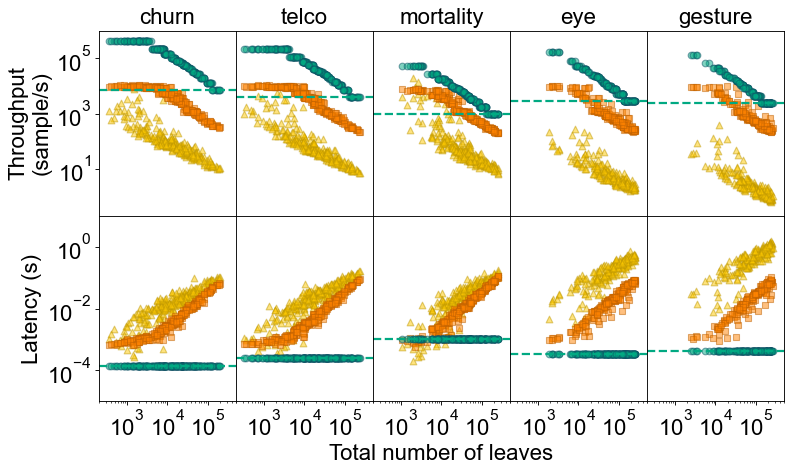

In [6]:
benchmarks.plotScatterMultipleDataset()

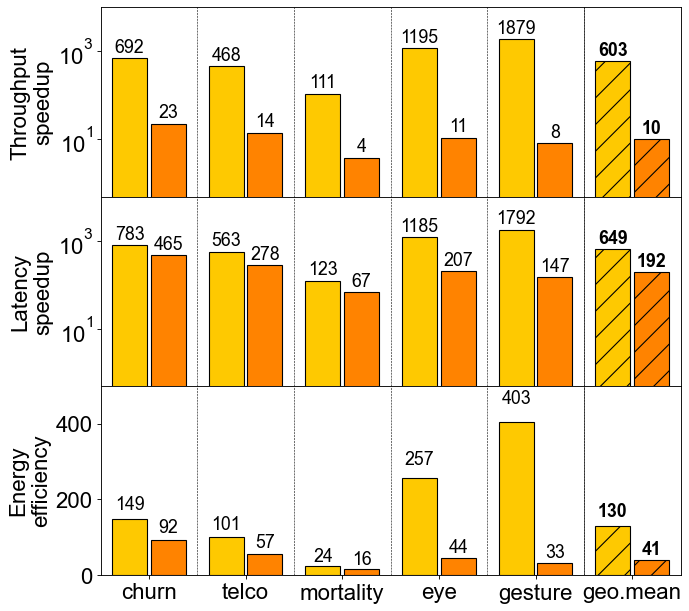

In [7]:
benchmarks.plotRelBarWithEnergy()

Total Power: 30.8 W, Total Area: 106.2 mm²


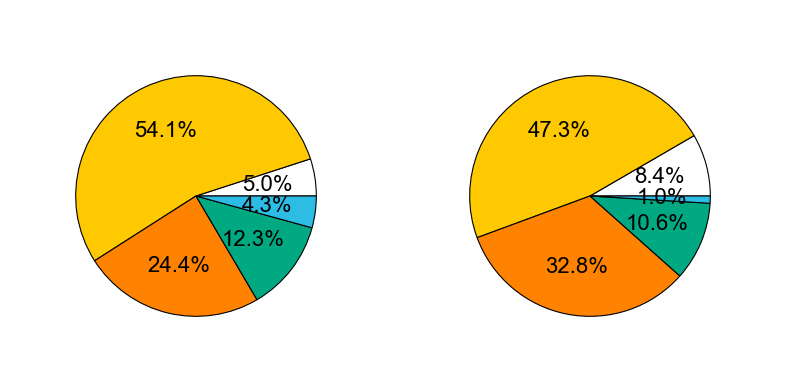

In [8]:
benchmarks.plotPie(dataset='mortality')